In [1]:
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import numpy as np

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import cell_order_log_analysis
import sys
sys.path.append('../radio_api')
import constants

In [2]:
FIG_SIZE = (8,4)
FONT_SIZE = 17
LINE_STYLE = (0,(4,4))
LINE_WIDTH = 3.5
SAVE_FIG = False

In [3]:
RESERVATION = 'RES131834'
SCENARIO = 1033
EXP_LABEL = 'withContention'
reservation_data_dir = '../data/' + RESERVATION + '/'

if (SAVE_FIG):
    reservation_out_dir = '../outputs/' + RESERVATION + '/'
    if (not os.path.exists(reservation_out_dir)):
        os.mkdir(reservation_out_dir)

OUTLIER_PERCENTILE = 5 # Percentile to clip-off from both ends for each SLA period
LAT_S_IDX = 1
THP_S_IDX = 0
SLICES = [LAT_S_IDX, THP_S_IDX]
S_BUDGET_NAME ={
    LAT_S_IDX: 'slice_delay_budget_msec',
    THP_S_IDX: 'slice_tx_rate_budget_mbps'
}
S_METRICS = {
    LAT_S_IDX: 'filtered_rtt_msec',
    THP_S_IDX: 'filtered_mbps'
}

In [4]:
def ApEn(U, m, r) -> float:
    """Approximate_entropy."""

    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [
            len([1 for x_j in x if _maxdist(x_i, x_j) <= r]) / (N - m + 1.0)
            for x_i in x
        ]
        return (N - m + 1.0) ** (-1) * sum(np.log(C))

    N = len(U)

    return abs(_phi(m + 1) - _phi(m))

In [5]:
def filter_bs_sla_stats(bs_data, budgets, ts_start, sla_period, apen_m, apen_r):

    for user_id, supply_times in budgets['supply_times'].items():
        port_offset = int(user_id[0].split('.')[-1])
        sid = port_offset % constants.SLICE_NUM
        
        bs_data[sid]['filtered_ts_sec'] = []
        bs_data[sid]['filtered_lat_msec'] = []
        bs_data[sid]['filtered_thp_mbps'] = []
        bs_data[sid]['filtered_cqi_apen'] = []
        for supply_time in supply_times:
            ts_filter = np.logical_and(bs_data[sid]['raw_ts_sec'] >= supply_time,
                                       bs_data[sid]['raw_ts_sec'] < supply_time + sla_period + 1)
            if (not ts_filter.any()):
                continue

            sla_ts_sec = bs_data[sid]['raw_ts_sec'][ts_filter]
            bs_data[sid]['filtered_ts_sec'].append(np.max(sla_ts_sec))

            sla_lat_msec = bs_data[sid]['raw_lat_msec'][ts_filter]
            lat_outlier_filter = np.logical_and(sla_lat_msec <= np.percentile(sla_lat_msec, 100 - OUTLIER_PERCENTILE),
                                                sla_lat_msec >= np.percentile(sla_lat_msec, OUTLIER_PERCENTILE))
            if (lat_outlier_filter.any()):
                bs_data[sid]['filtered_lat_msec'].append(np.mean(sla_lat_msec[lat_outlier_filter]))
            else:
                bs_data[sid]['filtered_lat_msec'].append(np.median(sla_lat_msec))

            sla_thp_mbps = bs_data[sid]['raw_tx_mbps'][ts_filter]
            thp_outlier_filter = np.logical_and(sla_thp_mbps <= np.percentile(sla_thp_mbps, 100 - OUTLIER_PERCENTILE),
                                                sla_thp_mbps >= np.percentile(sla_thp_mbps, OUTLIER_PERCENTILE))
            if (thp_outlier_filter.any()):
                bs_data[sid]['filtered_thp_mbps'].append(np.mean(sla_thp_mbps[thp_outlier_filter]))
            else:
                bs_data[sid]['filtered_thp_mbps'].append(np.median(sla_thp_mbps))

            bs_data[sid]['filtered_cqi_apen'].append(ApEn(bs_data[sid]['raw_cqi'][ts_filter], apen_m, apen_r))

        for key, stats in bs_data[sid].items():
            if ('filtered' in key):
                bs_data[sid][key] = np.array(bs_data[sid][key])

In [6]:
def filter_ue_sla_stats(ue_data, sid, sla_period):

    ue_data[sid]['filtered_ts_sec'] = []
    ue_data[sid]['filtered_rtt_msec'] = []
    ue_data[sid]['filtered_mbps'] = []
    for supply_time in ue_data[sid]['supply_times']:
        ts_filter = np.logical_and(ue_data[sid]['raw_ts_sec'] >= supply_time,
                                   ue_data[sid]['raw_ts_sec'] < supply_time + sla_period + 1)
        if (not ts_filter.any()):
            continue

        sla_ts_sec = ue_data[sid]['raw_ts_sec'][ts_filter]
        ue_data[sid]['filtered_ts_sec'].append(np.max(sla_ts_sec))

        sla_rtt_msec = ue_data[sid]['raw_rtt_msec'][ts_filter]
        lat_outlier_filter = np.logical_and(sla_rtt_msec <= np.percentile(sla_rtt_msec, 100 - OUTLIER_PERCENTILE),
                                            sla_rtt_msec >= np.percentile(sla_rtt_msec, OUTLIER_PERCENTILE))
        if (lat_outlier_filter.any()):
            ue_data[sid]['filtered_rtt_msec'].append(np.mean(sla_rtt_msec[lat_outlier_filter]))
        else:
            ue_data[sid]['filtered_rtt_msec'].append(np.median(sla_rtt_msec))

        sla_mbps = ue_data[sid]['raw_mbps'][ts_filter]
        thp_outlier_filter = np.logical_and(sla_mbps <= np.percentile(sla_mbps, 100 - OUTLIER_PERCENTILE),
                                            sla_mbps >= np.percentile(sla_mbps, OUTLIER_PERCENTILE))
        if (thp_outlier_filter.any()):
            ue_data[sid]['filtered_mbps'].append(np.mean(sla_mbps[thp_outlier_filter]))
        else:
            ue_data[sid]['filtered_mbps'].append(np.median(sla_mbps))

    ue_data[sid]['filtered_ts_sec'] = np.array(ue_data[sid]['filtered_ts_sec'])
    ue_data[sid]['filtered_rtt_msec'] = np.array(ue_data[sid]['filtered_rtt_msec'])
    ue_data[sid]['filtered_mbps'] = np.array(ue_data[sid]['filtered_mbps'])

In [7]:
apen_m, apen_r = 1, 0.05

exp_names = ['10sp-05rp', '30sp-05rp', '60sp-05rp', '30sp-025rp', '30sp-10rp', '30sp-20rp']
bs_data = {}
bs_budgets = {}
ts_start = {}
ue_data = {}
for exp_name in exp_names:
    sla_period = float(exp_name.split('sp')[0])
    bs_log_filename = \
        reservation_data_dir + 'cell-order-{}-{}-{}.log'.format(SCENARIO, exp_name, EXP_LABEL)
    bs_data[exp_name], bs_budgets[exp_name], ts_start[exp_name] = \
        cell_order_log_analysis.read_cell_order_log(bs_log_filename)
    filter_bs_sla_stats(bs_data[exp_name], bs_budgets[exp_name], ts_start[exp_name], sla_period, apen_m, apen_r)
    ue_data[exp_name] = {}
    for s_idx in SLICES:
        ue_log_filename = \
            reservation_data_dir + 'cell-order-ue{}-{}-{}-{}.log'.format(s_idx+2, SCENARIO, exp_name, EXP_LABEL)
        cur_data, ue_s_id, _ = \
            cell_order_log_analysis.read_cell_order_ue_log(ue_log_filename, ts_start[exp_name])
        assert ue_s_id in bs_data[exp_name].keys()
        ue_data[exp_name][ue_s_id] = cur_data
        filter_ue_sla_stats(ue_data[exp_name], ue_s_id, sla_period)

Data for 624.4730000495911 seconds has been extracted
UE Data for 601.7760000228882 seconds has been extracted
UE Data for 619.7760000228882 seconds has been extracted
Data for 631.4869999885559 seconds has been extracted
UE Data for 628.4509999752045 seconds has been extracted
UE Data for 502.45099997520447 seconds has been extracted
Data for 1180.00200009346 seconds has been extracted
UE Data for 1106.0650000572205 seconds has been extracted
UE Data for 1176.0650000572205 seconds has been extracted
Data for 625.3020000457764 seconds has been extracted
UE Data for 599.7720000743866 seconds has been extracted
UE Data for 620.7720000743866 seconds has been extracted
Data for 620.5499999523163 seconds has been extracted
UE Data for 617.1150000095367 seconds has been extracted
UE Data for 615.1150000095367 seconds has been extracted
Data for 679.9969999790192 seconds has been extracted
UE Data for 617.7960000038147 seconds has been extracted
UE Data for 675.7960000038147 seconds has been 

In [8]:
sla_periods = ['10', '30', '60']
rp_for_sp_exp = '05'
sla_periods_over_budget = []
sla_periods_under_budget = []
sla_periods_within_budget = []
for exp_name in ['{}sp-{}rp'.format(sp, rp_for_sp_exp) for sp in sla_periods]:
    n_sla, n_violations, n_over_achieves = 0, 0, 0
    for s_idx in SLICES:
        n_sla += len(ue_data[exp_name][s_idx][S_METRICS[s_idx]])
        n_over_budget = sum(ue_data[exp_name][s_idx][S_METRICS[s_idx]] >= bs_budgets[exp_name][S_BUDGET_NAME[s_idx]][s_idx][1])
        n_under_budget = sum(ue_data[exp_name][s_idx][S_METRICS[s_idx]] < bs_budgets[exp_name][S_BUDGET_NAME[s_idx]][s_idx][0])
        if (s_idx == LAT_S_IDX):
            n_violations += n_over_budget
            n_over_achieves += n_under_budget
        elif(s_idx == THP_S_IDX):
            n_violations += n_under_budget 
            n_over_achieves += n_over_budget
        else:
            print("Unrecognized SLA type! Don't know how to categorize achieved performance.")
    sla_periods_over_budget.append(n_violations / n_sla * 100)
    sla_periods_under_budget.append(n_over_achieves / n_sla * 100)
    sla_periods_within_budget.append((n_sla - n_violations - n_over_achieves) / n_sla * 100)

In [9]:
realloc_periods = ['0.25', '0.5', '1.0', '2.0']
sp_for_rp_exp = '30'
realloc_periods_over_budget = []
realloc_periods_under_budget = []
realloc_periods_within_budget = []
for exp_name in ['{}sp-{}rp'.format(sp_for_rp_exp, rp.replace('.', '')) for rp in realloc_periods]:
    n_sla, n_violations, n_over_achieves = 0, 0, 0
    for s_idx in SLICES:
        n_sla += len(ue_data[exp_name][s_idx][S_METRICS[s_idx]])
        n_over_budget = sum(ue_data[exp_name][s_idx][S_METRICS[s_idx]] >= bs_budgets[exp_name][S_BUDGET_NAME[s_idx]][s_idx][1])
        n_under_budget = sum(ue_data[exp_name][s_idx][S_METRICS[s_idx]] < bs_budgets[exp_name][S_BUDGET_NAME[s_idx]][s_idx][0])
        if (s_idx == LAT_S_IDX):
            n_violations += n_over_budget
            n_over_achieves += n_under_budget
        elif(s_idx == THP_S_IDX):
            n_violations += n_under_budget 
            n_over_achieves += n_over_budget
        else:
            print("Unrecognized SLA type! Don't know how to categorize achieved performance.")
    realloc_periods_over_budget.append(n_violations / n_sla * 100)
    realloc_periods_under_budget.append(n_over_achieves / n_sla * 100)
    realloc_periods_within_budget.append((n_sla - n_violations - n_over_achieves) / n_sla * 100)

In [10]:
# Calculate the CQI stability within an SLA
cqi_entropy = []
for sp in sla_periods:
    exp_name = '{}sp-{}rp'.format(sp, rp_for_sp_exp)
    filtered_cqi_apen = np.array([])
    for s_idx in SLICES:
        filtered_cqi_apen = np.concatenate((filtered_cqi_apen, bs_data[exp_name][s_idx]['filtered_cqi_apen']))
    cqi_entropy.append(np.mean(filtered_cqi_apen))
cqi_entropy = np.array(cqi_entropy)
print(cqi_entropy)

[0.50545586 0.80133147 1.0452442 ]


In [11]:
# Calculate the overhead of negotiation traffic for each SLA period

sla_periods_float = np.array([10, 30, 60])

#   'msg_type'      : The purpose of the message
#   'client_ip'     : Identifies the UE 
#   'negotiation_id': Identifies the SLA
#   'sla_period'    : Length of each incremental SLA
#   'service_type'  : Primary constraint of the SLA
#   'remote_ip'     : Remote end of the SLA traffic
#   'budgets'       : Requested performance values
#   'price'         : Cost of the SLA
#   'timestamp'     : Time of the message
#   'signature'     : Proof of the payment
cell_order_msg_size_bits = 2 + 32 + 16 + 8 + 4 + 32 + 128 + 32 + 64 + 64
pkt_header_size_bits = 40 * 8
msg_overhead_per_period_bits = 2 * (pkt_header_size_bits + cell_order_msg_size_bits)
msg_overhead_bps = msg_overhead_per_period_bits / sla_periods_float

In [12]:
# Calculate the overhead of control traffic for each reallocation peiod

realloc_periods_float = np.array([0.25, 0.5, 1, 2])
scope_log_period_sec = 0.25
scope_log_size_bits = 124 * 8 * len(SLICES)
prb_alloc_msg_size_bits = 5 * 8 * len(SLICES)
num_log_lines_per_realloc = realloc_periods_float / scope_log_period_sec
control_overhead_bits_per_period = num_log_lines_per_realloc * scope_log_size_bits + pkt_header_size_bits * 2 + prb_alloc_msg_size_bits
control_overhead_kbps = np.divide(control_overhead_bits_per_period, realloc_periods_float) / 1e3
print(control_overhead_kbps)

# plt.plot(realloc_periods, control_overhead_kbits_per_sec)

[10.816  9.376  8.656  8.296]


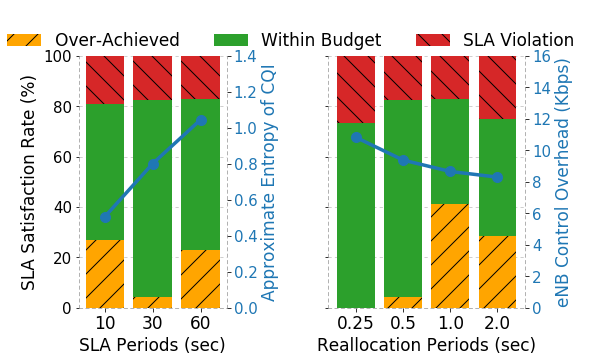

In [13]:
#@title
f, (a0, dummy, a1) = plt.subplots(1, 3, figsize=FIG_SIZE, 
                           gridspec_kw={'width_ratios': [3, 1, 4]}, sharey=True)

a0.bar(sla_periods, sla_periods_under_budget, color='orange', hatch='/')
a0.bar(sla_periods, sla_periods_within_budget, bottom=sla_periods_under_budget, 
       color='C2')
a0.bar(sla_periods, sla_periods_over_budget, 
       bottom=[i+j for i,j in zip(sla_periods_under_budget, sla_periods_within_budget)], 
       color='C3', hatch='\\')

a0.set_xlabel('SLA Periods (sec)', fontsize=FONT_SIZE)
for label in (a0.get_xticklabels()): 
  label.set_fontsize(FONT_SIZE)
a0.set_ylabel('SLA Satisfaction Rate (%)', fontsize=FONT_SIZE)
for label in (a0.get_yticklabels()): 
  label.set_fontsize(FONT_SIZE-2)
a0.set_ylim([0, 100])
a0.set_axisbelow(True)
a0.grid(axis='y', alpha=0.75, linestyle=LINE_STYLE)
a0.spines['top'].set_visible(False)
a0.spines['right'].set_visible(False)

a2 = a0.twinx()  # instantiate a second axes that shares the same x-axis
a2_color = 'C0'
a2.set_ylabel('Approximate Entropy of CQI', color=a2_color, fontsize=FONT_SIZE)
a2.plot(sla_periods, cqi_entropy, 
        color=a2_color, linewidth=LINE_WIDTH, marker='o', markersize=10)
a2.tick_params(axis='y', labelcolor=a2_color, labelsize=FONT_SIZE-2)
a2.set_ylim([0, 1.4])
a2.yaxis.set_ticks(np.arange(0,1.5,0.2))
a2.spines['top'].set_visible(False)
a2.spines['left'].set_visible(False)
a2.spines['bottom'].set_visible(False)

a1.bar(realloc_periods, realloc_periods_under_budget, 
       color='orange', label='Over-Achieved', hatch='/')
a1.bar(realloc_periods, realloc_periods_within_budget, 
       bottom=realloc_periods_under_budget, color='C2', label='Within Budget')
a1.bar(realloc_periods, realloc_periods_over_budget, 
       bottom=[i+j for i,j in zip(realloc_periods_under_budget, realloc_periods_within_budget)], 
       color='C3', hatch='\\', label='SLA Violation')
a1.set_xlabel('Reallocation Periods (sec)', fontsize=FONT_SIZE)
for label in (a1.get_xticklabels()): 
  label.set_fontsize(FONT_SIZE)
a1.set_axisbelow(True)
a1.grid(axis='y', alpha=0.75, linestyle=LINE_STYLE)
# a1.spines['left'].set_visible(False)
a1.spines['top'].set_visible(False)
a1.spines['right'].set_visible(False)

a3 = a1.twinx()  # instantiate a second axes that shares the same x-axis
a3_color = 'C0'
a3.set_ylabel('eNB Control Overhead (Kbps)', color=a3_color, fontsize=FONT_SIZE)
a3.plot(realloc_periods, control_overhead_kbps, 
        color=a3_color, linewidth=LINE_WIDTH, marker='o', markersize=10)
a3.tick_params(axis='y', labelcolor=a3_color, labelsize=FONT_SIZE-2)
a3.set_ylim((0, 8 * len(SLICES)))
a3.spines['top'].set_visible(False)
a3.spines['left'].set_visible(False)
a3.spines['bottom'].set_visible(False)

a0.spines["right"].set_linestyle(LINE_STYLE)
a0.spines["right"].set_alpha(0.75)
a0.spines["right"].set_color('gray')
a0.spines["left"].set_linestyle(LINE_STYLE)
a0.spines["left"].set_alpha(0.75)
a0.spines["left"].set_color('gray')
a0.spines["top"].set_linestyle(LINE_STYLE)
a0.spines["top"].set_alpha(0.75)
a0.spines["top"].set_color('gray')
a0.spines["bottom"].set_linestyle(LINE_STYLE)
a0.spines["bottom"].set_alpha(0.75)
a0.spines["bottom"].set_color('gray')
a2.spines["right"].set_linestyle(LINE_STYLE)
a2.spines["right"].set_alpha(0.75)
a2.spines["right"].set_color('gray')
a2.spines["left"].set_linestyle(LINE_STYLE)
a2.spines["left"].set_alpha(0.75)
a2.spines["left"].set_color('gray')
a2.spines["top"].set_linestyle(LINE_STYLE)
a2.spines["top"].set_alpha(0.75)
a2.spines["top"].set_color('gray')
a2.spines["bottom"].set_linestyle(LINE_STYLE)
a2.spines["bottom"].set_alpha(0.75)
a2.spines["bottom"].set_color('gray')
a1.spines["right"].set_linestyle(LINE_STYLE)
a1.spines["right"].set_alpha(0.75)
a1.spines["right"].set_color('gray')
a1.spines["left"].set_linestyle(LINE_STYLE)
a1.spines["left"].set_alpha(0.75)
a1.spines["left"].set_color('gray')
a1.spines["top"].set_linestyle(LINE_STYLE)
a1.spines["top"].set_alpha(0.75)
a1.spines["top"].set_color('gray')
a1.spines["bottom"].set_linestyle(LINE_STYLE)
a1.spines["bottom"].set_alpha(0.75)
a1.spines["bottom"].set_color('gray')
a3.spines["right"].set_linestyle(LINE_STYLE)
a3.spines["right"].set_alpha(0.75)
a3.spines["right"].set_color('gray')
a3.spines["left"].set_linestyle(LINE_STYLE)
a3.spines["left"].set_alpha(0.75)
a3.spines["left"].set_color('gray')
a3.spines["top"].set_linestyle(LINE_STYLE)
a3.spines["top"].set_alpha(0.75)
a3.spines["top"].set_color('gray')
a3.spines["bottom"].set_linestyle(LINE_STYLE)
a3.spines["bottom"].set_alpha(0.75)
a3.spines["bottom"].set_color('gray')

dummy.axis('off')
dummy.spines['left'].set_visible(False)
dummy.spines['top'].set_visible(False)
dummy.spines['right'].set_visible(False)
dummy.spines['bottom'].set_visible(False)

f.legend(loc='upper center', frameon=False, fontsize=FONT_SIZE, ncol=3,
              bbox_to_anchor=[0.505,1.2])

plt.subplots_adjust(top=1.0)
# plt.tight_layout()

if (SAVE_FIG):
  plt.savefig(reservation_out_dir + 'parameters_{}.pdf'.format(EXP_LABEL), bbox_inches='tight')
plt.show()